Install Packages/Libraries

In [1]:
%pip install --upgrade pip
%pip install torch torchvision torchaudio

%pip install pandas
%pip install datasets
%pip install peft
%pip install transformers
%pip install transformers[torch]
%pip install 'accelerate>=0.26.0'

%pip install matplotlib

%pip install evaluate
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import Packages/Libraries

In [2]:
import os, math, torch,time, evaluate, pandas as pd, matplotlib.pyplot as plt, numpy as np
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType

/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configurations

In [3]:
USE_LORA                    = False
DATA_DIR                    = "outputs/bigcode-ts-output-50000-formatted"
METADATA_CSV                = "outputs/bigcode-ts-output-50000-types.csv"
OUTPUT_DIR                  = "outputs/typescriptmate-50000"
BATCH_SIZE                  = 4
MAX_LENGTH                  = 512
EPOCHS                      = 5
LR                          = 5e-5
GRAD_CLIP                   = 0.0
SEED                        = 42
WEIGHT_DECAY                = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

Count number of TypeScipt files in folder

In [4]:
file_count = sum(len(files) for _, _, files in os.walk(DATA_DIR))
print("Total files:", file_count)

Total files: 46053


Check if MPS (Accelerated PyTorch Training for Apple Silicon) is supported

In [5]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


True
True


Load metadata for Type Awareness

In [6]:
df = pd.read_csv(METADATA_CSV)
for col in ["TypeAliases", "Interfaces"]:
    if col in df.columns:
        df[col] = df[col].fillna("")
print(f"Loaded {len(df)} metadata rows")

Loaded 46012 metadata rows


Attach file text

In [7]:
dataset_meta = Dataset.from_pandas(df, preserve_index=False)

def add_text(example):
    path = example["File"]
    if not os.path.isabs(path):
        path = os.path.join(DATA_DIR, path)
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            example["text"] = f.read()
    except:
        example["text"] = ""
    return example

dataset_meta = dataset_meta.map(add_text, batched=False)

Map: 100%|██████████| 46012/46012 [00:05<00:00, 8456.16 examples/s]


Filter bad examples

In [8]:
dataset_meta = dataset_meta.filter(lambda ex: ex["text"].strip() != "")
print("Non-empty examples:", len(dataset_meta))

Filter: 100%|██████████| 46012/46012 [00:00<00:00, 125003.12 examples/s]

Non-empty examples: 46012


Split and filter train and validation data for annotated examples

In [9]:
splits = dataset_meta.train_test_split(test_size=0.1, seed=SEED)
datasets = DatasetDict({
    "train": splits["train"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"]),
    "validation": splits["test"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"])
})
print("Filtered split:")
print("  • train:", len(datasets["train"]))
print("  • validation:", len(datasets["validation"]))

Filter: 100%|██████████| 4602/4602 [00:00<00:00, 45518.77 examples/s]

Filtered split:
  • train: 6468
  • validation: 697


Tokenize

In [10]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

to_remove = df.columns.tolist() + ["text"]
tokenized = datasets.map(
    tokenize_fn,
    batched=True,
    remove_columns=to_remove
)

Map: 100%|██████████| 697/697 [00:07<00:00, 98.62 examples/s]


Sanity check on tokens

In [11]:
valid_count = sum(
    any(tok != tokenizer.eos_token_id for tok in ex["input_ids"])
    for ex in tokenized["train"]
)
print(f"Usable tokenized examples: {valid_count} / {len(tokenized['train'])}")

Usable tokenized examples: 6468 / 6468


Collator & base Model

In [12]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
base_model = AutoModelForCausalLM.from_pretrained("gpt2")

Apply LoRA if enabled

In [13]:
if USE_LORA:
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=4,
        lora_alpha=16,
        lora_dropout=0.0,
        target_modules=["c_attn"]  # you can inspect model to try others
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
else:
    model = base_model

Move model to supported device

In [14]:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

model.to(device)

Using device: mps


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, 
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY, 
    max_grad_norm=GRAD_CLIP,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=True,
)

Trainer with loss logger

In [16]:
class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print("LOGS:", logs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    callbacks=[LossLogger()]
)

Training

In [17]:
trainer.train()

/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,1.666100,1.619252
1000,1.531500,1.546311
1500,1.474600,1.502556
2000,1.442600,1.481350
2500,1.378700,1.470323
3000,1.383500,1.455247
3500,1.341700,1.448773
4000,1.337900,1.445167


LOGS: {'loss': 2.1341, 'learning_rate': 4.877475247524753e-05, 'epoch': 0.12368583797155226}
LOGS: {'loss': 1.8983, 'learning_rate': 4.753712871287129e-05, 'epoch': 0.24737167594310452}
LOGS: {'loss': 1.8132, 'learning_rate': 4.629950495049505e-05, 'epoch': 0.37105751391465674}
LOGS: {'loss': 1.752, 'learning_rate': 4.506188118811881e-05, 'epoch': 0.49474335188620905}
LOGS: {'loss': 1.6661, 'learning_rate': 4.382425742574257e-05, 'epoch': 0.6184291898577613}
LOGS: {'eval_loss': 1.6192518472671509, 'eval_runtime': 44.7969, 'eval_samples_per_second': 15.559, 'eval_steps_per_second': 3.907, 'epoch': 0.6184291898577613}
LOGS: {'loss': 1.6959, 'learning_rate': 4.2586633663366335e-05, 'epoch': 0.7421150278293135}
LOGS: {'loss': 1.692, 'learning_rate': 4.1349009900990096e-05, 'epoch': 0.8658008658008658}
LOGS: {'loss': 1.6469, 'learning_rate': 4.0111386138613864e-05, 'epoch': 0.9894867037724181}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.5646, 'learning_rate': 3.8873762376237625e-05, 'epoch': 1.1125541125541125}
LOGS: {'loss': 1.5315, 'learning_rate': 3.7636138613861386e-05, 'epoch': 1.2362399505256647}
LOGS: {'eval_loss': 1.546310544013977, 'eval_runtime': 61.137, 'eval_samples_per_second': 11.401, 'eval_steps_per_second': 2.862, 'epoch': 1.2362399505256647}
LOGS: {'loss': 1.5636, 'learning_rate': 3.639851485148515e-05, 'epoch': 1.3599257884972171}
LOGS: {'loss': 1.5589, 'learning_rate': 3.516089108910891e-05, 'epoch': 1.4836116264687693}
LOGS: {'loss': 1.5619, 'learning_rate': 3.392326732673268e-05, 'epoch': 1.6072974644403217}
LOGS: {'loss': 1.5128, 'learning_rate': 3.268564356435644e-05, 'epoch': 1.730983302411874}
LOGS: {'loss': 1.4746, 'learning_rate': 3.14480198019802e-05, 'epoch': 1.8546691403834261}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'eval_loss': 1.5025557279586792, 'eval_runtime': 58.4935, 'eval_samples_per_second': 11.916, 'eval_steps_per_second': 2.992, 'epoch': 1.8546691403834261}
LOGS: {'loss': 1.5506, 'learning_rate': 3.021039603960396e-05, 'epoch': 1.9783549783549783}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.5087, 'learning_rate': 2.8972772277227722e-05, 'epoch': 2.101422387136673}
LOGS: {'loss': 1.4713, 'learning_rate': 2.773514851485149e-05, 'epoch': 2.225108225108225}
LOGS: {'loss': 1.4384, 'learning_rate': 2.649752475247525e-05, 'epoch': 2.3487940630797772}
LOGS: {'loss': 1.4426, 'learning_rate': 2.5259900990099013e-05, 'epoch': 2.4724799010513294}
LOGS: {'eval_loss': 1.481350064277649, 'eval_runtime': 57.4694, 'eval_samples_per_second': 12.128, 'eval_steps_per_second': 3.045, 'epoch': 2.4724799010513294}
LOGS: {'loss': 1.4544, 'learning_rate': 2.4022277227722774e-05, 'epoch': 2.596165739022882}
LOGS: {'loss': 1.4424, 'learning_rate': 2.2784653465346535e-05, 'epoch': 2.7198515769944343}
LOGS: {'loss': 1.4318, 'learning_rate': 2.1547029702970297e-05, 'epoch': 2.8435374149659864}
LOGS: {'loss': 1.4343, 'learning_rate': 2.030940594059406e-05, 'epoch': 2.9672232529375386}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.3787, 'learning_rate': 1.9071782178217823e-05, 'epoch': 3.090290661719233}
LOGS: {'eval_loss': 1.470322608947754, 'eval_runtime': 70.5952, 'eval_samples_per_second': 9.873, 'eval_steps_per_second': 2.479, 'epoch': 3.090290661719233}
LOGS: {'loss': 1.3729, 'learning_rate': 1.7834158415841584e-05, 'epoch': 3.2139764996907854}
LOGS: {'loss': 1.3625, 'learning_rate': 1.659653465346535e-05, 'epoch': 3.3376623376623376}
LOGS: {'loss': 1.4109, 'learning_rate': 1.535891089108911e-05, 'epoch': 3.4613481756338897}
LOGS: {'loss': 1.4246, 'learning_rate': 1.4121287128712871e-05, 'epoch': 3.5850340136054424}
LOGS: {'loss': 1.3835, 'learning_rate': 1.2883663366336634e-05, 'epoch': 3.7087198515769946}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'eval_loss': 1.4552470445632935, 'eval_runtime': 72.52, 'eval_samples_per_second': 9.611, 'eval_steps_per_second': 2.413, 'epoch': 3.7087198515769946}
LOGS: {'loss': 1.4102, 'learning_rate': 1.1646039603960397e-05, 'epoch': 3.8324056895485468}
LOGS: {'loss': 1.3787, 'learning_rate': 1.0408415841584158e-05, 'epoch': 3.956091527520099}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.3993, 'learning_rate': 9.170792079207921e-06, 'epoch': 4.079158936301793}
LOGS: {'loss': 1.3944, 'learning_rate': 7.933168316831684e-06, 'epoch': 4.202844774273346}
LOGS: {'loss': 1.3417, 'learning_rate': 6.695544554455446e-06, 'epoch': 4.326530612244898}
LOGS: {'eval_loss': 1.4487731456756592, 'eval_runtime': 64.0833, 'eval_samples_per_second': 10.876, 'eval_steps_per_second': 2.731, 'epoch': 4.326530612244898}
LOGS: {'loss': 1.3827, 'learning_rate': 5.4579207920792085e-06, 'epoch': 4.45021645021645}
LOGS: {'loss': 1.3249, 'learning_rate': 4.220297029702971e-06, 'epoch': 4.573902288188003}
LOGS: {'loss': 1.3601, 'learning_rate': 2.9826732673267327e-06, 'epoch': 4.6975881261595545}
LOGS: {'loss': 1.3739, 'learning_rate': 1.7450495049504953e-06, 'epoch': 4.821273964131107}
LOGS: {'loss': 1.3379, 'learning_rate': 5.074257425742574e-07, 'epoch': 4.944959802102659}


/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'eval_loss': 1.4451674222946167, 'eval_runtime': 72.3487, 'eval_samples_per_second': 9.634, 'eval_steps_per_second': 2.419, 'epoch': 4.944959802102659}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


LOGS: {'train_runtime': 13949.773, 'train_samples_per_second': 2.318, 'train_steps_per_second': 0.29, 'total_flos': 8440777801728000.0, 'train_loss': 1.5062432610162413, 'epoch': 4.994434137291281}


TrainOutput(global_step=4040, training_loss=1.5062432610162413, metrics={'train_runtime': 13949.773, 'train_samples_per_second': 2.318, 'train_steps_per_second': 0.29, 'total_flos': 8440777801728000.0, 'train_loss': 1.5062432610162413, 'epoch': 4.994434137291281})

Save model, tokenizer and deploy

In [18]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
trainer.save_model(OUTPUT_DIR)

Basic evaluation

In [19]:
eval_results = trainer.evaluate()

print("Full eval results:", eval_results)

if eval_results.get("eval_loss") is not None and not math.isnan(eval_results["eval_loss"]):
    print("Validation Perplexity: ", math.exp(eval_results["eval_loss"]))
else:
    print("NaN eval loss")

/opt/homebrew/Caskroom/miniconda/base/envs/dissertation_apple/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'eval_loss': 1.4451674222946167, 'eval_runtime': 63.5384, 'eval_samples_per_second': 10.97, 'eval_steps_per_second': 2.754, 'epoch': 4.994434137291281}
Full eval results: {'eval_loss': 1.4451674222946167, 'eval_runtime': 63.5384, 'eval_samples_per_second': 10.97, 'eval_steps_per_second': 2.754, 'epoch': 4.994434137291281}
Validation Perplexity:  4.242562382892963


Convert the trainer log history into a DataFrame

In [20]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
print(df)

      loss  learning_rate     epoch  step  eval_loss  eval_runtime  \
0   2.1341   4.877475e-05  0.123686   100        NaN           NaN   
1   1.8983   4.753713e-05  0.247372   200        NaN           NaN   
2   1.8132   4.629950e-05  0.371058   300        NaN           NaN   
3   1.7520   4.506188e-05  0.494743   400        NaN           NaN   
4   1.6661   4.382426e-05  0.618429   500        NaN           NaN   
5      NaN            NaN  0.618429   500   1.619252       44.7969   
6   1.6959   4.258663e-05  0.742115   600        NaN           NaN   
7   1.6920   4.134901e-05  0.865801   700        NaN           NaN   
8   1.6469   4.011139e-05  0.989487   800        NaN           NaN   
9   1.5646   3.887376e-05  1.112554   900        NaN           NaN   
10  1.5315   3.763614e-05  1.236240  1000        NaN           NaN   
11     NaN            NaN  1.236240  1000   1.546311       61.1370   
12  1.5636   3.639851e-05  1.359926  1100        NaN           NaN   
13  1.5589   3.51608

Plot training loss vs global step

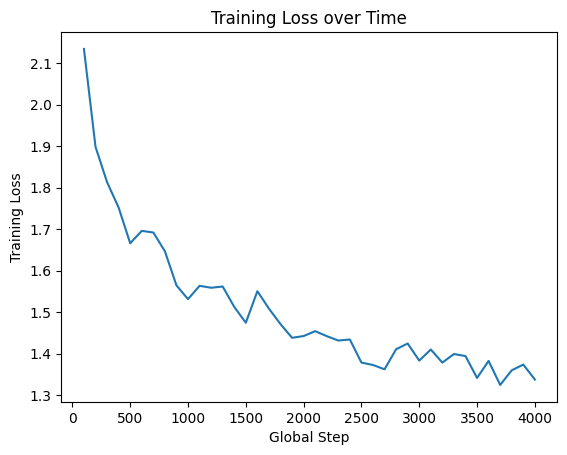

In [21]:
train_df = df[df["loss"].notna()]
plt.plot(train_df["step"], train_df["loss"])
plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time")
plt.show()

Plot training perplexity vs global step

/var/folders/1t/7n837bkd5sd19nbzclkmhv2m0000gn/T/ipykernel_48612/702312287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["perplexity"] = train_df["loss"].apply(math.exp)


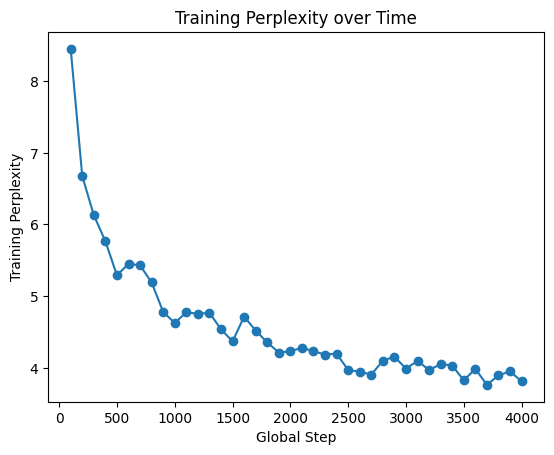

In [22]:
train_df["perplexity"] = train_df["loss"].apply(math.exp)
plt.figure()
plt.plot(train_df["step"], train_df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Training Perplexity")
plt.title("Training Perplexity over Time")
plt.show()

Load each checkpoint’s weights into your model

In [23]:
# ckpts = [
#     "checkpoint-500","checkpoint-1000","checkpoint-1500",
#     "checkpoint-2000","checkpoint-2500","checkpoint-3000",
#     "checkpoint-3500","checkpoint-4000","checkpoint-4500",
#     "checkpoint-4851"
# ]

ckpts = [
    "checkpoint-345"
]

records = []
for ckpt in ckpts:
    ckpt_path = f"{OUTPUT_DIR}/{ckpt}"

    # 1) Reload the model weights
    model = AutoModelForCausalLM.from_pretrained(ckpt_path)
    model.to(trainer.args.device)

    # 2) Patch the Trainer’s model
    trainer.model = model

    # 3) Run evaluation on your validation split
    metrics = trainer.evaluate()        # no args here

    # 4) Record step & loss (& perplexity)
    step = int(ckpt.split("-")[-1])
    loss = metrics["eval_loss"]
    records.append({
      "step": step,
      "eval_loss": loss,
      "perplexity": math.exp(loss)
    })

df = pd.DataFrame(records).sort_values("step")

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'outputs/typescriptmate-50000/checkpoint-345'. Use `repo_type` argument if needed.

Plot evaluation loss vs global step

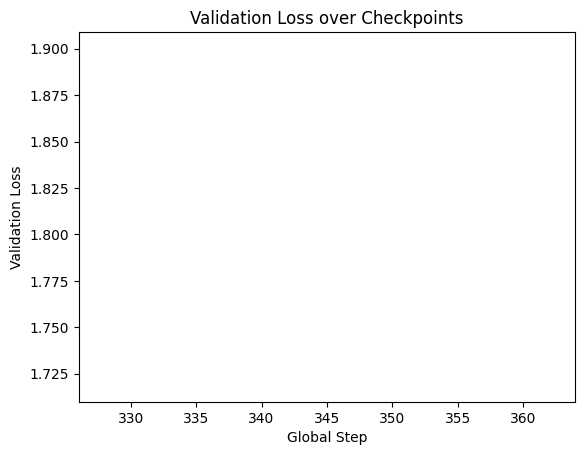

In [26]:
plt.figure()
plt.plot(df["step"], df["eval_loss"])
plt.xlabel("Global Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Checkpoints")
plt.show()

Convert loss to perplexity for easier interpretation: perplexity = exp(loss)

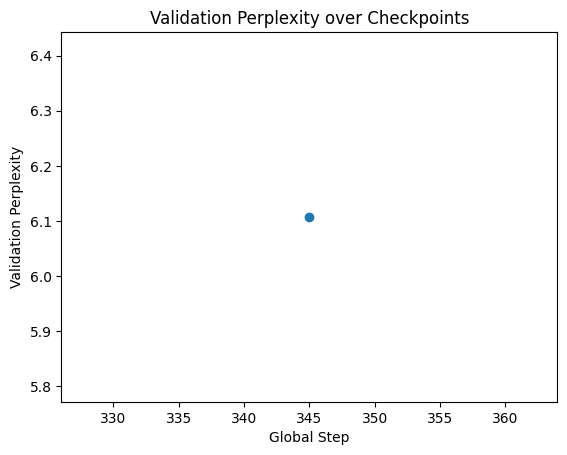

In [ ]:
plt.figure()
plt.plot(df["step"], df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity over Checkpoints")
plt.show()

Top-5 Token Accuracy and MRR over validation set

In [28]:
def stream_topk_mrr(model, trainer, k=5, batch_size=1):
    """
    Streams through the Trainer’s eval_dataloader batch-by-batch,
    accumulates top-k matches and reciprocal ranks,
    and keeps memory use small.
    """
    # Put model in eval mode & grab device
    model.eval()
    device = next(model.parameters()).device
    
    # Use the Trainer’s built-in eval dataloader (with correct collation)
    loader: DataLoader = trainer.get_eval_dataloader()
    
    total_tokens = 0
    topk_matches = 0
    rr_sum = 0.0

    with torch.no_grad():
        for batch in loader:
            # batch is a dict of torch.Tensor already
            labels = batch.pop("labels").to(device)   # shape (bs, seq_len)
            # move all other inputs to device
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # forward
            logits = model(**inputs).logits.cpu().numpy()  # (bs, seq_len, vocab_size)
            lbls   = labels.cpu().numpy()                 # (bs, seq_len)

            # mask out padding tokens
            mask = lbls != -100                             # (bs, seq_len)
            flat_logits = logits[mask].reshape(-1, logits.shape[-1])  # (N_toks, V)
            flat_labels = lbls[mask].reshape(-1)                     # (N_toks,)

            # Top-k matches via argpartition (cheap per-row)
            topk_idxs = np.argpartition(flat_logits, -k, axis=-1)[:, -k:]
            topk_matches += np.sum([flat_labels[i] in topk_idxs[i]
                                    for i in range(flat_labels.shape[0])])

            # MRR: rank = 1 + # of logits > true_logit
            true_scores = flat_logits[np.arange(flat_labels.shape[0]), flat_labels]
            ranks = 1 + np.sum(flat_logits > true_scores[:, None], axis=1)
            rr_sum += np.sum(1.0 / ranks)

            total_tokens += flat_labels.shape[0]

    topk_acc = topk_matches / total_tokens
    mrr      = rr_sum / total_tokens
    return topk_acc, mrr

# Usage:
top5_acc, mrr = stream_topk_mrr(model, trainer, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"MRR:             {mrr:.4f}")


Top-5 Accuracy: 0.1536
MRR:             0.1287


Top-5 Accuracy bar chart

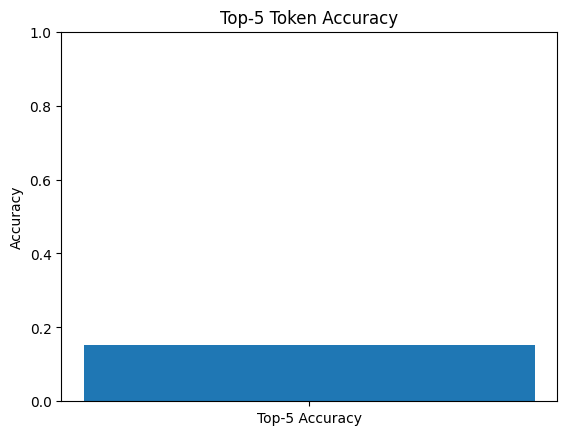

In [29]:
plt.figure()
plt.bar(['Top-5 Accuracy'], [top5_acc])
plt.ylim(0, 1)
plt.title('Top-5 Token Accuracy')
plt.ylabel('Accuracy')
plt.show()

MRR bar chart

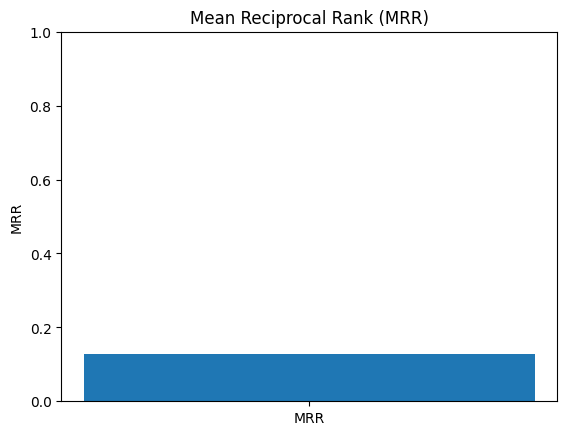

In [30]:
plt.figure()
plt.bar(['MRR'], [mrr])
plt.ylim(0, 1)
plt.title('Mean Reciprocal Rank (MRR)')
plt.ylabel('MRR')
plt.show()

Inference Latency Histogram
Measure per-sample inference latency and visualize

Mean latency: 0.0756s
Std  latency: 0.0914s


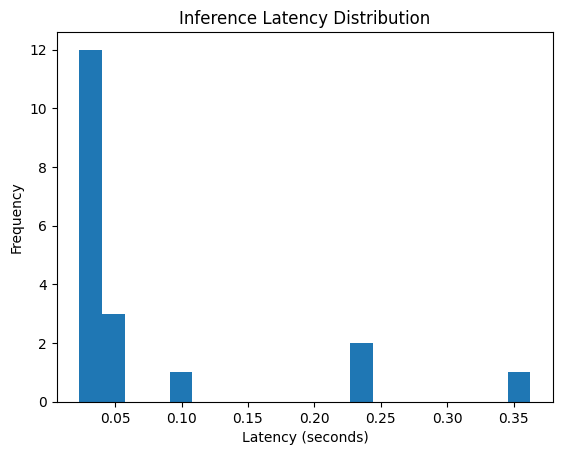

In [ ]:
model.eval()
device = next(model.parameters()).device
loader = trainer.get_eval_dataloader()

latencies = []
with torch.no_grad():
    for batch in loader:
        batch.pop("labels", None)
        inputs = {k: v.to(device) for k, v in batch.items()}
        start = time.monotonic()
        _ = model(**inputs)
        end = time.monotonic()
        latencies.append(end - start)

latencies = np.array(latencies)

print(f"Mean latency: {latencies.mean():.4f}s")
print(f"Std  latency: {latencies.std():.4f}s")

plt.figure()
plt.hist(latencies, bins=20)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Inference Latency Distribution")
plt.show()
